## <u> Table of Contents </u>
* [Import the DataSet](#1)
* [Dataset Division](#222)
    * [Dataset Normalization](#2222)
    * [Correlation Matrix](#22)
        * [Zero DataSet](#vc)
        * [Nonzero DataSet](#vcc)
* [Scale the Data](#am)
* [Check Data Distribution](#dd)
    * [Principal Component Analysis](#ddd)
    * [t-SNE](#dddd)
* [Save Dataset](#22.2)
<br>

## Import the DataSet  <a class="anchor" id="1"></a>

In [1]:
#!pip install plotly
#!pip install joypy
#!pip install pyvis
#!pip install prince
#!pip install pyclustering
#!pip install clusteval
#!pip install kmodes
#!pip install gower
#!pip install scikit-learn-extra
#!pip install minisom
#!pip install fuzzy-c-means

In [2]:
# Remove the warnings

import warnings; warnings.simplefilter('ignore')

# Basic Packages

import pandas as pd
import numpy as np
from numpy import asarray
from numpy import save

# Set a random state 

np.random.seed(9)

# Notebook Setup

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
pd.set_option('display.max_columns', None)

# Plotting Packages

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from matplotlib.widgets import SpanSelector
from bokeh.models import Div, RangeSlider, Spinner
from bokeh.plotting import figure, show
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from joypy import joyplot
from pyvis.network import Network
from IPython.display import Image
import plotly.offline as pyo

# Set notebook mode to work in offline

pyo.init_notebook_mode()

# Packages for Transformations

import scipy.special
import prince
from sklearn.preprocessing import PowerTransformer
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Packages for Clustering

from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from clusteval import clusteval
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering 
import gower
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from minisom import MiniSom
from sklearn.cluster import Birch
import scipy.cluster.hierarchy as shc
from fcmeans import FCM
from sklearn.manifold import TSNE

# Packages to measure performance

from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from scipy.spatial import distance as ssd
from pyclustering.cluster.kmedoids import kmedoids

In [3]:
# Import the dataset 

final_df = pd.read_csv('/Users/cirillogirardi/Desktop/Dissertation/final_df.csv')
final_df.drop(columns=['Unnamed: 0'], inplace=True)

## Dataset Division <a class="anchor" id="222"></a>

<br>

**Business Idea**
<br>

Given the high presence of zero values for most financial variables it would be ideal to separate the datasets into two. The first dataset would only contain zero values while the other one would contain non-zero values. In other words the second dataset would be the (~(first_dataset)). 
<br>

<br>

We can design kernel estimate plots to see how the datasets would look without zero values. In this case we know that due to the presence of outliers we are going to have to transform the datasets eventually. When we plot the log of the features through a KDE plot, the plots consider the 0 values as infinite or NaNs and thus will not include them.

<br> <br>

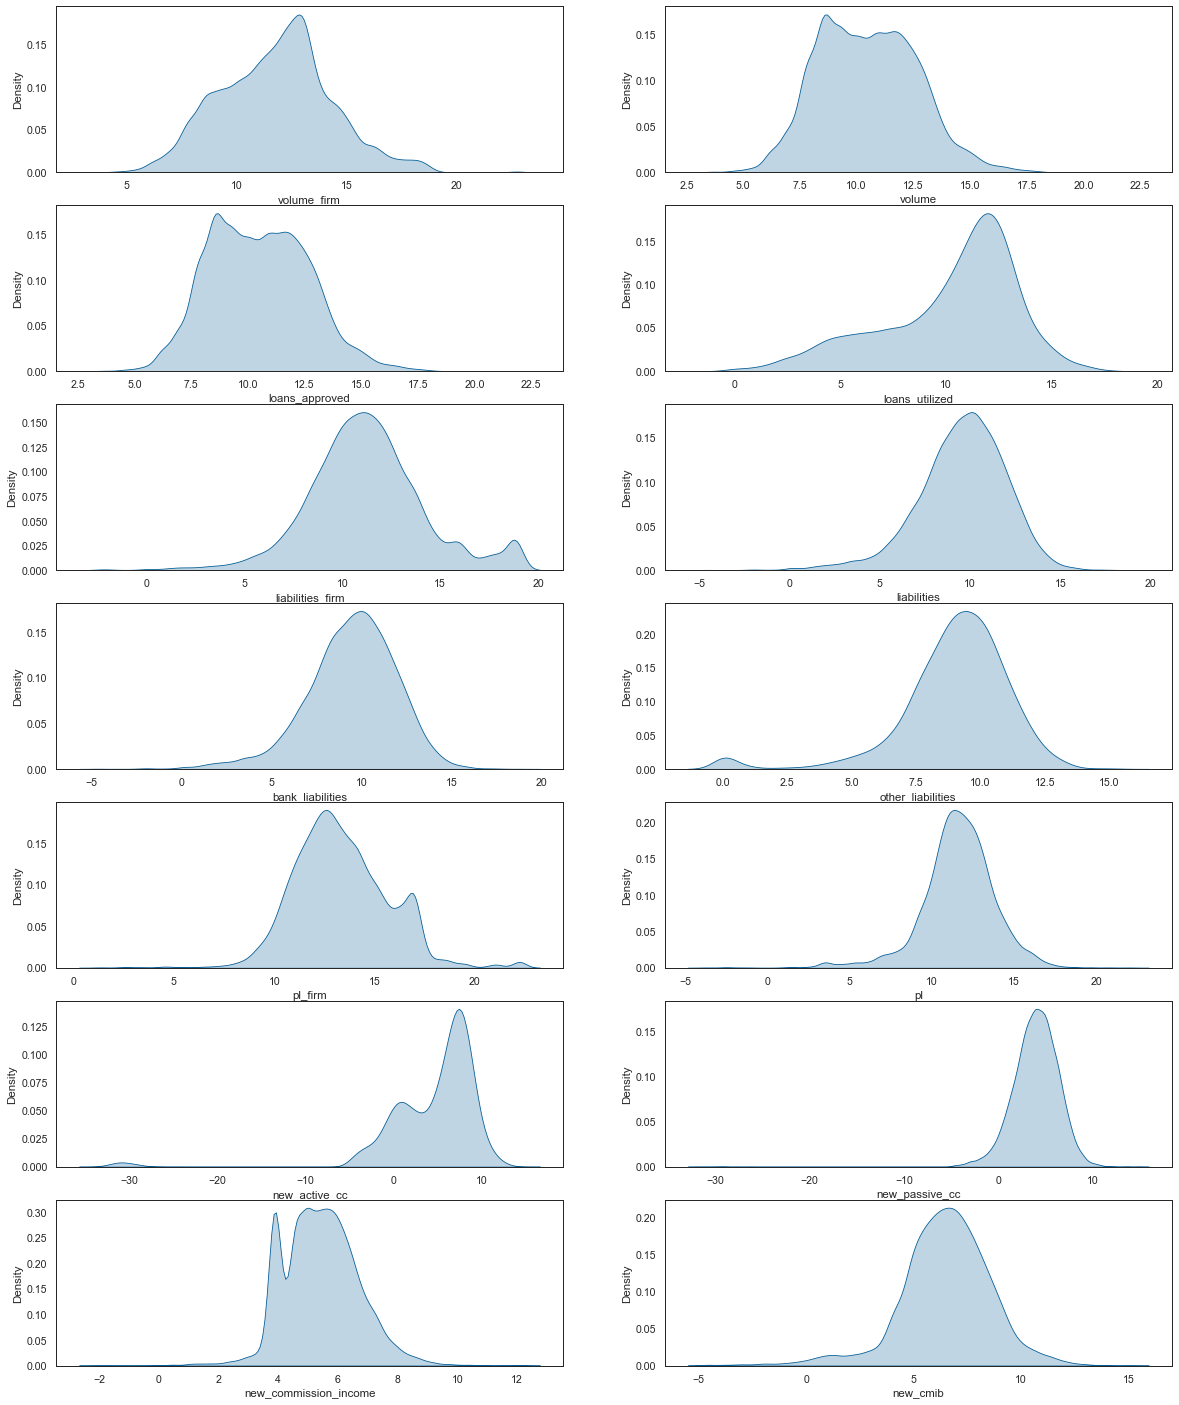

In [4]:
# select the financial variables (i.e. the numerical variables of the dataset) and create a new df

colu = ['volume_firm', 'volume', 'loans_approved', 'loans_utilized', 'liabilities_firm', 'liabilities',
       'bank_liabilities', 'other_liabilities', 'pl_firm', 'pl', 'new_active_cc', 'new_passive_cc',
       'new_commission_income', 'new_cmib']

# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
sns.set_palette("BrBG_r")

plt.figure(figsize=(20,25))

# plot a subplot for each column to visualise the density distirbution of the features

for i, col in enumerate(colu):
    ax = plt.subplot(7,2, i+1)
    sns.kdeplot(np.log(final_df[col]), color='#005b96', shade= True, ax = ax)
plt.show()

<br>

The distributions in this case seem quite normal. As a consequence this might be a good approach to solving the bimodal distirbution.

<br>

In order to come up with the first dataset we have to identify the financial variable that presents the most zeros. Once that is the case we have to examine whether the intersection between that variable and the other financial variables represent a high number.

<br>

In [5]:
# print the number of 0 values per column

print('The features have the following zero values: \n \n' +
      'Volume: ' + str(len(final_df[final_df['volume']==0])) + '\n' +
      'Volume Firm: ' + str(len(final_df[final_df['volume_firm']==0])) + '\n' +
      'Liabilities: ' + str(len(final_df[final_df['liabilities']==0])) + '\n' +
      'Liabilities Firm: ' + str(len(final_df[final_df['liabilities_firm']==0])) + '\n' +
      'PL: ' + str(len(final_df[final_df['pl']==0])) + '\n' +
      'PL Firm: ' + str(len(final_df[final_df['pl_firm']==0])) + '\n')

The features have the following zero values: 
 
Volume: 5186
Volume Firm: 0
Liabilities: 3209
Liabilities Firm: 0
PL: 0
PL Firm: 0



<br>

As a consequence, we must see whether the intersection of zero values between volume and liabilities is a relatively high number.

<br> <br>

In [6]:
# select only the data points in which liabilities and volume are both equal to zero

final_df[(final_df['liabilities']== 0) & (final_df['volume']== 0)]

client_type  legal  branch  volume_firm  volume  loans_approved  \
5              0.0   16.0    10.0     31792.82     0.0             0.0   
18             0.0    1.0    24.0     15000.00     0.0             0.0   
30             0.0    1.0     8.0     50000.00     0.0             0.0   
44             0.0    6.0    20.0     33587.45     0.0             0.0   
53             0.0   20.0     7.0      5000.00     0.0             0.0   
...            ...    ...     ...          ...     ...             ...   
17971          4.0    0.0     2.0    850000.00     0.0             0.0   
17978          4.0    0.0     7.0    737920.51     0.0             0.0   
17985          4.0    0.0     7.0    163058.15     0.0             0.0   
18003          4.0    0.0    10.0    308246.00     0.0             0.0   
18006          4.0    0.0     5.0     23414.94     0.0             0.0   

       loans_utilized  liabilities_firm  liabilities  bank_liabilities  \
5                 0.0           6103.29          0.0               0.0   
18                0.0           3946.86          0.0               0.0   
30                0.0          18225.73          0.0               0.0   
44                0.0           3508.36          0.0               0.0   
53                0.0          23271.90          0.0               0.0   
...               ...               ...          ...               ...   
17971             0.0          50954.16          0.0               0.0   
17978             0.0            151.78          0.0               0.0   
17985             0.0          74799.33          0.0               0.0   
18003             0.0          22763.69          0.0               0.0   
18006             0.0           5704.68          0.0               0.0   

       other_liabilities     pl_firm          pl  banking_products  \
5                    0.0    47870.67   11518.478               0.0   
18                   0.0    40068.08   39329.080               0.0   
30                   0.0    18000.00   18000.000               0.0   
44                   0.0   106018.08    2597.850               0.0   
53                   0.0    58849.54   13169.370               0.0   
...                  ...         ...         ...               ...   
17971                0.0   642000.00  109061.074               0.0   
17978                0.0    39521.00   24800.542               0.0   
17985                0.0  1053811.00  664122.000               0.0   
18003                0.0   118000.00   53239.440               0.0   
18006                0.0   243954.58  243954.580               1.0   

       other_products  p_membership  p_KK  p_creditcard  p_bankloans  \
5                 0.0           1.0   1.0           0.0          1.0   
18                0.0           1.0   1.0           1.0          0.0   
30                0.0           1.0   1.0           0.0          0.0   
44                0.0           1.0   1.0           0.0          1.0   
53                0.0           1.0   1.0           0.0          0.0   
...               ...           ...   ...           ...          ...   
17971             0.0           1.0   1.0           0.0          1.0   
17978             0.0           1.0   1.0           0.0          1.0   
17985             0.0           1.0   1.0           1.0          1.0   
18003             0.0           1.0   1.0           0.0          1.0   
18006             0.0           1.0   1.0           0.0          1.0   

       p_fixeddeposits  p_WP2Depot  p_propertyinsurance  p_companyinsurance  \
5                  1.0         0.0                  0.0                 0.0   
18                 0.0         0.0                  0.0                 0.0   
30                 0.0         0.0                  0.0                 0.0   
44                 1.0         0.0                  1.0                 1.0   
53                 1.0         0.0                  0.0                 0.0   
...                ...         ...               

<br>

In this case, we would only have approximately 2000 observations with 0 liability. This is good enough.

<br> <br>

**Business Rationale**
<br>

If we use the two datasets abovementioned this might be quite useful because we would naturally have two segmentations. The first one would only have zero values for volume, entailing that the companies are not borrowing from the bank. This allows the relationship managers to focus on other aspects, such as marketing, products, etc. <br>
On the other hand, the second dataset would focus on companies that have borrowed from the bank. This allows to allocate relationship managers based on risks, current loan status, etc.

<br> <br>

In [7]:
# create a dataset for zero volume

zero_df = final_df[(final_df['volume']== 0)]

# reset the index

zero_df.reset_index(inplace=True, drop=True)

# create a copy of the dataframe to apply potential transformations

tra_zero = zero_df.copy()

In [8]:
zero_df.head(10)

client_type  legal  branch  volume_firm  volume  loans_approved  \
0          0.0   16.0    10.0     31792.82     0.0             0.0   
1          0.0    1.0    15.0      2000.00     0.0             0.0   
2          0.0    1.0    24.0     15000.00     0.0             0.0   
3          0.0   40.0    24.0     15000.00     0.0             0.0   
4          0.0    4.0    15.0     25661.36     0.0             0.0   
5          0.0   43.0     4.0      3750.00     0.0             0.0   
6          0.0    1.0    15.0      3067.75     0.0             0.0   
7          0.0    6.0    13.0      7000.00     0.0             0.0   
8          0.0    1.0     8.0     50000.00     0.0             0.0   
9          0.0   20.0     6.0      1000.00     0.0             0.0   

   loans_utilized  liabilities_firm  liabilities  bank_liabilities  \
0             0.0           6103.29         0.00              0.00   
1             0.0          14272.99      2192.09           2192.09   
2             0.0           3946.86         0.00              0.00   
3             0.0           3946.86      3946.86           3946.86   
4             0.0           5046.78        15.22             15.22   
5             0.0           1411.30      1411.30           1411.30   
6             0.0          35978.19     14763.38              0.00   
7             0.0            646.02        11.88             11.88   
8             0.0          18225.73         0.00              0.00   
9             0.0           2057.41       763.94            763.94   

   other_liabilities    pl_firm         pl  banking_products  other_products  \
0               0.00   47870.67  11518.478               0.0             0.0   
1               0.00   58154.85  15089.890               1.0             0.0   
2               0.00   40068.08  39329.080               0.0             0.0   
3               0.00   40068.08    739.000               1.0             0.0   
4               0.00   58833.35  25626.740               1.0             0.0   
5               0.00    2904.68    254.600               2.0             0.0   
6           14763.38   29980.07  31792.410               1.0             1.0   
7               0.00   74861.74  59075.118               1.0             0.0   
8               0.00   18000.00  18000.000               0.0             0.0   
9               0.00  134524.64  85031.020               1.0             0.0   

   p_membership  p_KK  p_creditcard  p_bankloans  p_fixeddeposits  p_WP2Depot  \
0           1.0   1.0           0.0          1.0              1.0         0.0   
1           1.0   1.0           0.0          0.0              1.0         0.0   
2           1.0   1.0           1.0          0.0              0.0         0.0   
3           1.0   1.0           1.0          0.0              0.0         0.0   
4           1.0   1.0           0.0          0.0              1.0         0.0   
5           1.0   1.0           0.0          0.0              0.0         1.0   
6           1.0   1.0           1.0          0.0              1.0         1.0   
7           1.0   1.0           0.0          0.0              1.0         0.0   
8           1.0   1.0           0.0          0.0              0.0         0.0   
9           0.0   1.0           0.0          0.0              0.0         0.0   

   p_propertyinsurance  p_companyinsurance  p_DZ  p_DZP  p_unionfunds  \
0                  0.0                 0.0   0.0    0.0           0.0   
1                  0.0                 0.0   0.0    0.0           0.0   
2                  0.0                 0.0   0.0    0.0           0.0   
3                  0.0                 0.0   0.0    0.0           0.0   
4                  0.0                 0.0   0.0    0.0           0.0   
5                  0.0                 0.0   0.0    0.0           0.0   
6                  0.0                 0.0   0.0    0.0           0.0   
7                  0.0                 0.0   0.0    0.0           1.0   
8                  0.0         

In [9]:
# create a dataset for non-zero volume

nonzero_df = final_df[(final_df['volume'] != 0)]

# reset the index

nonzero_df.reset_index(inplace=True, drop=True)

# create a copy of the dataframe to apply potential transformations

tra_nonzero = nonzero_df.copy()

In [10]:
nonzero_df.head(10)

client_type  legal  branch  volume_firm    volume  loans_approved  \
0          0.0   39.0    23.0     12988.79  12988.79        12988.79   
1          0.0    1.0    21.0      4250.00   3500.00         3500.00   
2          0.0   39.0    21.0      4250.00    500.00          500.00   
3          0.0   39.0    21.0      4250.00    250.00          250.00   
4          0.0   43.0    12.0     31792.82  31792.82        31792.82   
5          0.0   43.0     6.0      5000.00   5000.00         5000.00   
6          0.0    1.0    14.0     10000.00   5000.00         5000.00   
7          0.0    1.0    14.0     10000.00   5000.00         5000.00   
8          0.0    1.0    12.0      9500.00   9000.00         9000.00   
9          0.0    1.0    12.0      9500.00    500.00          500.00   

   loans_utilized  liabilities_firm  liabilities  bank_liabilities  \
0        12988.79            748.17       748.17            748.17   
1          207.72          13659.72     12751.18          12277.28   
2            0.00          13659.72       908.54            908.54   
3          195.91          13659.72         0.00              0.00   
4        28792.82           6103.29      6103.29           6103.29   
5            0.00          42573.98     42573.98          42573.98   
6            0.00           6325.46      2893.96           2893.96   
7            0.00           6325.46      3431.50           3431.50   
8            0.00           3266.87      3266.87           3266.87   
9          267.09           3266.87         0.00              0.00   

   other_liabilities    pl_firm         pl  banking_products  other_products  \
0                0.0    7388.77    7388.77               2.0             0.0   
1              473.9  191147.14  178332.68               5.0             2.0   
2                0.0  191147.14   84446.84               1.0             0.0   
3                0.0  191147.14   12814.46               1.0             0.0   
4                0.0   47870.67   47870.67               3.0             0.0   
5                0.0   58914.05   58914.05               4.0             0.0   
6                0.0   77928.46   26109.75               1.0             0.0   
7                0.0   77928.46   51818.71               2.0             0.0   
8                0.0  150013.50  134427.69               2.0             0.0   
9                0.0  150013.50   15585.81               1.0             0.0   

   p_membership  p_KK  p_creditcard  p_bankloans  p_fixeddeposits  p_WP2Depot  \
0           0.0   1.0           0.0          1.0              0.0         0.0   
1           1.0   1.0           1.0          0.0              1.0         0.0   
2           1.0   1.0           1.0          0.0              1.0         0.0   
3           1.0   1.0           1.0          0.0              1.0         0.0   
4           1.0   1.0           0.0          1.0              1.0         0.0   
5           1.0   1.0           0.0          0.0              0.0         1.0   
6           1.0   1.0           0.0          0.0              0.0         1.0   
7           1.0   1.0           0.0          0.0              0.0         1.0   
8           1.0   1.0           0.0          0.0              0.0         0.0   
9           1.0   1.0           0.0          0.0              0.0         0.0   

   p_propertyinsurance  p_companyinsurance  p_DZ  p_DZP  p_unionfunds  \
0                  0.0                 0.0   0.0    0.0           0.0   
1                  0.0                 0.0   0.0    0.0           1.0   
2                  0.0                 0.0   0.0    0.0           1.0   
3                  0.0                 0.0   0.0    0.0           1.0   
4                  0.0                 0.0   0.0    0.0           0.0   
5                  0.0                 0.0   0.0    0.0           0.0   
6                  0.0                 0.0   0.0    0.0           0.0   
7                  0.0                 0.0   0.0    0.0           0.0   
8        

Accordingly we then drop the features which do not belong in the respective datasets <br>

In [11]:

# we drop loans because the dataset zero_df does not have any active loans
# In other words, 'volume', 'loans_approved', 'loans_utilized' are all zero

tra_zero.drop(columns=['volume', 'loans_approved', 'loans_utilized'], inplace = True)

<br>

# DataSet Normalization <a class="anchor" id="2222"></a>

Following the separation of the datasets the next steps include the normalization of the dataset and the standardization of the aformentioned. <br><br>

To apply transformations we first have to select the numerical features which might portray skewness. The features are the following: <br>
- volume_firm
- volume
- loans_approved
- loans_utilized
- liabilities_firm
- liabilities
- bank_liabilities
- other_liabilities
- pl_firm
- pl
- new_active_cc
- new_passive_cc
- new_commission_income
- new_cmib

In [12]:
# we select the numerical variables for the zero dataset

col_z = tra_zero[['volume_firm', 'liabilities_firm',
                  'liabilities', 'bank_liabilities', 'other_liabilities',
                  'pl_firm', 'pl','new_active_cc', 'new_passive_cc',
                  'new_commission_income', 'new_cmib']]

# and the numerical variables for the nonzero dataset

col_n = tra_nonzero[['volume_firm', 'volume', 'loans_approved', 'loans_utilized', 'liabilities_firm',
                  'liabilities', 'bank_liabilities', 'other_liabilities',
                  'pl_firm', 'pl','new_active_cc', 'new_passive_cc',
                  'new_commission_income', 'new_cmib']]

Foremost we deal with the zero dataset. To find the correct transformations we observe the skewness of the features and we identify which ones need transforming. <br>

In [13]:
print('The skewness measurements are the following: \n' )
for i in col_z:
    print(str(i) + ': ' + str(col_z[i].skew()) + '\n')

The skewness measurements are the following: 

volume_firm: 29.21388491890769

liabilities_firm: 2.2678395220034613

liabilities: 20.925140144369667

bank_liabilities: 21.114475329064692

other_liabilities: 61.0936824039285

pl_firm: 12.151017178491017

pl: 55.78042931968141

new_active_cc: 47.034065227640355

new_passive_cc: -4.713971842261169

new_commission_income: 11.30860234782591

new_cmib: 16.06278144911958



Since all of the features need transformations we can proceed with testing different transformation techniques on all features. <br>
The transformation options are:
- Log 10
- Log 2
- Square Root
- Box Cox
- Yeo Johnson

In [14]:

print('\nThe following are the best transformations for the zero dataset. \n\n')

# we create a loop which applies the transformations to all selected features of the dataset

for i in col_z:
    try:
        l10 = np.log(col_z[i].skew())
    except:
        l10 = 100
    try:
        l2 = np.log2(col_z[i].skew())
    except:
        l2= 100
    try:
        sqrt = np.sqrt(col_z[i].skew())
    except:
        sqrt= 100
    try:
        box = pd.Series(stats.boxcox(col_z[i])[0]).skew()
    except:
        box= 100
    try:
        yeo = pd.Series(scipy.stats.yeojohnson(col_z[i])[0]).skew()
    except:
        yeo= 100
    
    # we create a dictionary with the values and transformations
    
    dic = {'Log10': l10, 'Log2': l2, 'Square Root': sqrt, 'Box-Cox': box, 'Yeo-Johnson': yeo}
    
    # we search for the solution closest to 0, insofar 0 represents a normally distirbuted data
    
    wanted_skewness = 0
   
    transformation, transformation_value = min(dic.items(), key=lambda x: abs(wanted_skewness - x[1]))

    # we print the best transformation and its result
    
    print(i + ': \n'+ transformation + ', ' + str(transformation_value) + '\n')


The following are the best transformations for the zero dataset. 


volume_firm: 
Box-Cox, -0.0005539750028232876

liabilities_firm: 
Box-Cox, -0.0033372351577790793

liabilities: 
Yeo-Johnson, -0.10894882945656637

bank_liabilities: 
Yeo-Johnson, -0.10301722984817

other_liabilities: 
Log10, 4.112408463187267

pl_firm: 
Yeo-Johnson, 0.013076176406788341

pl: 
Yeo-Johnson, 0.016419578227128456

new_active_cc: 
Yeo-Johnson, 2.027082565733187

new_passive_cc: 
Log10, nan

new_commission_income: 
Yeo-Johnson, -1.76266217460453

new_cmib: 
Log10, 2.776504884626104



New_passive_cc has a value of NaN. This is most likely due to its values being equal to zero. We must thus re-run the code for new_passive_cc and add a miniscule constant(i.e. 0.00001) to all values of new_passive_cc to avoid getting the log of 0. <br>

To do so we transform the loop into a function and we run the function for new_passive_cc. <br>

In [15]:
# we create a function and we add 0.00001 to all transformations

def transform(i):
    try:
        l10 = np.log(col_z[i]+0.00001.skew())
    except:
        l10 = 100
    try:
        l2 = np.log2(col_z[i]+0.00001.skew())
    except:
        l2= 100
    try:
        sqrt = np.sqrt(col_z[i]+0.00001.skew())
    except:
        sqrt= 100
    try:
        box = pd.Series(stats.boxcox(col_z[i]+0.00001)[0]).skew()
    except:
        box= 100
    try:
        yeo = pd.Series(scipy.stats.yeojohnson(col_z[i]+0.00001)[0]).skew()
    except:
        yeo= 100
    
    # we create a dictionary with the values and transformations
    
    dic = {'Log10': l10, 'Log2': l2, 'Square Root': sqrt, 'Box-Cox': box, 'Yeo-Johnson': yeo}
    
    # we search for the solution closest to 0, insofar 0 represents a normally distirbuted data
    
    wanted_skewness = 0
   
    transformation, transformation_value = min(dic.items(), key=lambda x: abs(wanted_skewness - x[1]))

    # we print the best transformation and its result
    
    print(i + ': \n'+ transformation + ', ' + str(transformation_value) + '\n')

In [16]:
# we run the function for new_passive_cc

transform('new_passive_cc')

new_passive_cc: 
Yeo-Johnson, 1.6134441950268354



Now that we have the optimal transformations, we can graphically portray all of the corrected features just to double-check their distirbutions <br>

In [17]:
# we group the features in their respective transformations 

log10 = col_z[['other_liabilities', 'new_cmib']]

box = col_z[['volume_firm', 'liabilities_firm']]

yeo = col_z[['liabilities', 'bank_liabilities','pl_firm', 'pl','new_active_cc','new_commission_income']]

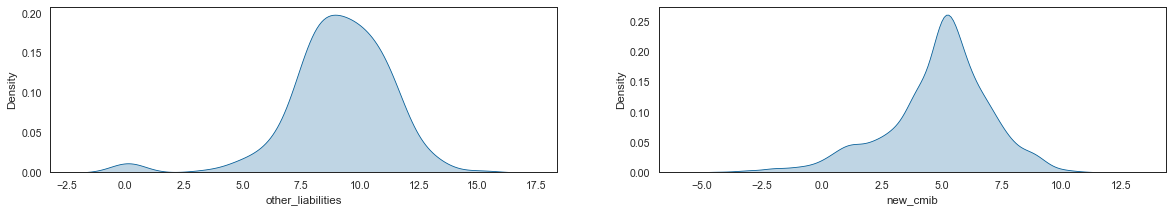

In [18]:
# we plot the features that should be logged

# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
sns.set_palette("BrBG_r")

plt.figure(figsize=(20,25))

for i, col in enumerate(log10):
    ax = plt.subplot(7,2, i+1)
    sns.kdeplot((np.log(log10[col])), color='#005b96',shade=True, ax = ax)
    
plt.show()

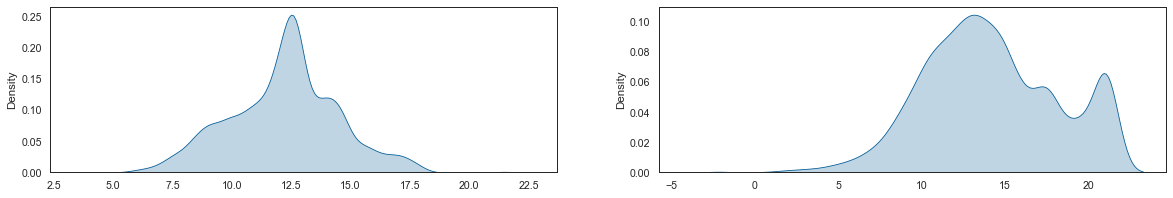

In [19]:
# we plot the features that should be box-coxxed

# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
sns.set_palette("BrBG_r")


plt.figure(figsize=(20,25))

for i, col in enumerate(box):
    ax = plt.subplot(7,2, i+1)
    sns.kdeplot(pd.Series(stats.boxcox(box[col])[0]), color='#005b96', shade=True, ax = ax)

plt.show()

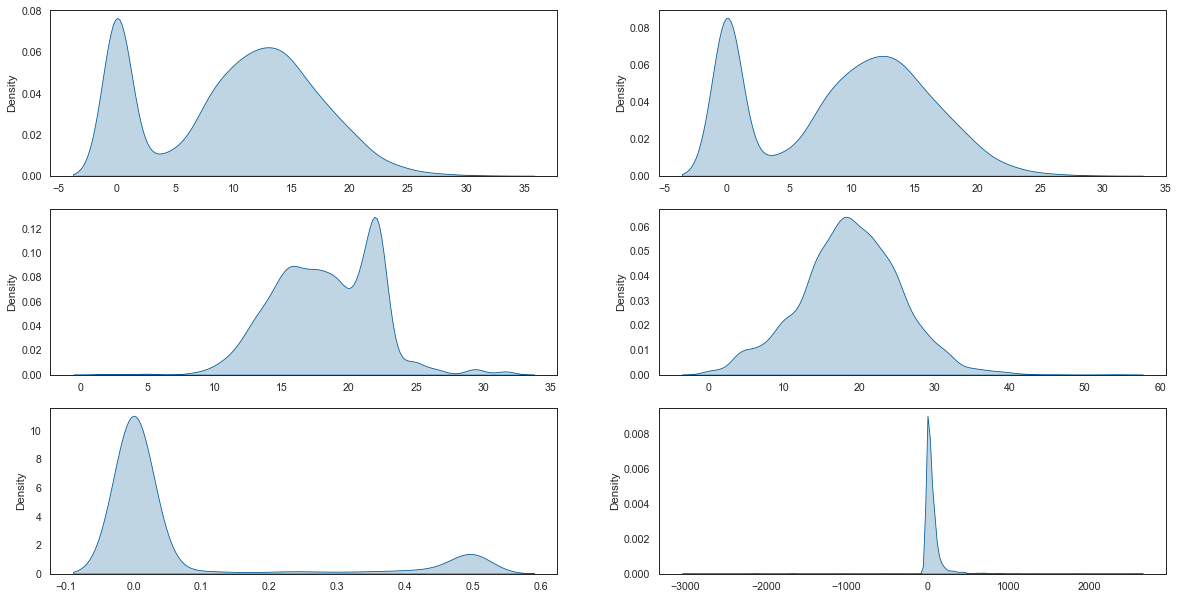

In [20]:
# we plot the features that should be yen-transformed

# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
sns.set_palette("BrBG_r")


plt.figure(figsize=(20,25))

for i, col in enumerate(yeo):
    ax = plt.subplot(7,2, i+1)
    sns.kdeplot(pd.Series(scipy.stats.yeojohnson(yeo[col])[0]), color='#005b96', shade=True, ax = ax)

plt.show()
    

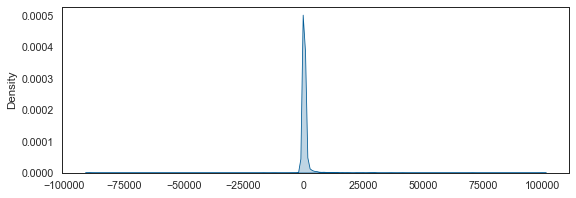

In [21]:
# we plot the new_passive_cc that should be yen-transformed with the constant 

# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
sns.set_palette("BrBG_r")


plt.figure(figsize=(20,25))

ax = plt.subplot(7,2, i+1)
sns.kdeplot(pd.Series(scipy.stats.yeojohnson(col_z['new_passive_cc']+0.00001)[0]), color='#005b96', shade=True, ax = ax)

plt.show()

Despite the transformations not being perfect, the distirbutions are fairly normal and are certainly better than how they were as raw data. <br>

We can thus proceed to applying the transformations. <br> <br>

<br>

**Zero Transformation**
<br>

We transform the following financial variables: <br>
    - volume_firm -> box-cox <br>
    - liabilities_firm -> box-cox <br>
    - liabilities -> yeo-johnson <br>
    - bank_liabilities -> yeo-johnson <br>
    - other_liabilities -> log10 <br>
    - pl_firm -> yeo-johnson <br>
    - pl -> yeo-johnson <br>
    - new_active_cc -> yeo-johnson <br>
    - new_passive_cc -> constant + yeo-johnson <br>
    - new_commissio_income -> yeo-johnson <br>
    - new_cmib -> log10
    
<br>
<br>
<br>

**Zero Dataset**

In [22]:
# volume_firm

pt = PowerTransformer(method='box-cox')
pt.fit(tra_zero[['volume_firm']])
n_9 = pt.lambdas_

tra_zero['volume_firm'] = scipy.special.boxcox(tra_zero['volume_firm'], n_9)

# liabilities_firm

pt = PowerTransformer(method='box-cox')
pt.fit(tra_zero[['liabilities_firm']])
n_10 = pt.lambdas_

tra_zero['liabilities_firm'] = scipy.special.boxcox(tra_zero['liabilities_firm'], n_10)

# liabilities

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_zero[['liabilities']])
n_11 = pt.lambdas_

tra_zero['liabilities'] = scipy.stats.yeojohnson(tra_zero['liabilities'], n_11)

# bank_liabilities

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_zero[['bank_liabilities']])
n_12 = pt.lambdas_

tra_zero['bank_liabilities'] = scipy.stats.yeojohnson(tra_zero['bank_liabilities'], n_12)

# other_liabilities

tra_zero['other_liabilities'] = np.log(tra_zero['other_liabilities'] + 0.00001) # we apply +0.00001 due to 0 values

# pl_firm

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_zero[['pl_firm']])
n_14 = pt.lambdas_

tra_zero['pl_firm'] = scipy.stats.yeojohnson(tra_zero['pl_firm'], n_14)

# pl

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_zero[['pl']])
n_15 = pt.lambdas_

tra_zero['pl'] = scipy.stats.yeojohnson(tra_zero['pl'], n_15)

# active_cc

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_zero[['new_active_cc']])
n_16 = pt.lambdas_

tra_zero['new_active_cc'] = scipy.stats.yeojohnson(tra_zero['new_active_cc'], n_16)

# passive_cc

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_zero[['new_passive_cc']])
n_17 = pt.lambdas_

tra_zero['new_passive_cc'] = scipy.stats.yeojohnson(tra_zero['new_passive_cc'] + 0.00001, n_17)

# commission_income

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_zero[['new_commission_income']])
n_18 = pt.lambdas_

tra_zero['new_commission_income'] = scipy.stats.yeojohnson(tra_zero['new_commission_income'], n_18)

# cmib

tra_zero['new_cmib'] = np.log(tra_zero['new_cmib'] + 0.00001)



<br>

Now we proceed to applying the same methodology to the nonzero dataset.

<br>

We first commence be finding the skewness of the features.

In [23]:
print('The skewness measurements are the following: \n' )
for i in col_n:
    print(str(i) + ': ' + str(col_n[i].skew()) + '\n')

The skewness measurements are the following: 

volume_firm: 41.2916604567858

volume: 80.51737719369791

loans_approved: 80.53855328474395

loans_utilized: 17.48283388255719

liabilities_firm: 13.061286899354306

liabilities: 67.57607152625954

bank_liabilities: 66.92743820564283

other_liabilities: 29.154914856573438

pl_firm: 11.957789961619941

pl: 52.67004280139943

new_active_cc: 22.268211783988427

new_passive_cc: 68.71231115409104

new_commission_income: 36.45808533053317

new_cmib: 27.730100222743985



We then identify the best possible transformations.

In [24]:
print('\nThe following are the best transformations for the nonzero dataset. \n\n')

# we create a loop which applies the transformations to all selected features of the dataset

for i in col_n:
    try:
        l10 = np.log(col_n[i].skew())
    except:
        l10 = 100
    try:
        l2 = np.log2(col_n[i].skew())
    except:
        l2= 100
    try:
        sqrt = np.sqrt(col_n[i].skew())
    except:
        sqrt= 100
    try:
        box = pd.Series(stats.boxcox(col_n[i])[0]).skew()
    except:
        box= 100
    try:
        yeo = pd.Series(scipy.stats.yeojohnson(col_n[i])[0]).skew()
    except:
        yeo= 100
    
    # we create a dictionary with the values and transformations
    
    dic = {'Log10': l10, 'Log2': l2, 'Square Root': sqrt, 'Box-Cox': box, 'Yeo-Johnson': yeo}
    
    # we search for the solution closest to 0, insofar 0 represents a normally distirbuted data
    
    wanted_skewness = 0
   
    transformation, transformation_value = min(dic.items(), key=lambda x: abs(wanted_skewness - x[1]))

    # we print the best transformation and its result
    
    print(i + ': \n'+ transformation + ', ' + str(transformation_value) + '\n')


The following are the best transformations for the nonzero dataset. 


volume_firm: 
Box-Cox, 0.0025969138445838427

volume: 
Box-Cox, 0.01025203933746415

loans_approved: 
Yeo-Johnson, 0.00816921462249647

loans_utilized: 
Yeo-Johnson, -0.0832341519811398

liabilities_firm: 
Yeo-Johnson, 0.03398803692575328

liabilities: 
Yeo-Johnson, -0.09729575818267823

bank_liabilities: 
Yeo-Johnson, -0.11301046954000749

other_liabilities: 
Yeo-Johnson, 1.9273914929297118

pl_firm: 
Yeo-Johnson, -0.07597976240076992

pl: 
Yeo-Johnson, 0.02130822372684577

new_active_cc: 
Log10, 3.103160180963498

new_passive_cc: 
Log10, 4.229928384834317

new_commission_income: 
Yeo-Johnson, -1.2272515999896971

new_cmib: 
Log10, 3.3225184738564235



Now we can visualize the above-stated transformations in order to double-check the distirbution of the nonzero dataset.

In [25]:
# we group the features in their respective transformations 

log10 = col_n[['new_active_cc', 'new_passive_cc', 'new_cmib']]

box = col_n[['volume_firm', 'volume']]

yeo = col_n[['loans_approved', 'loans_utilized', 'liabilities_firm', 'liabilities', 
             'bank_liabilities', 'other_liabilities', 'pl_firm', 'pl','new_commission_income']]

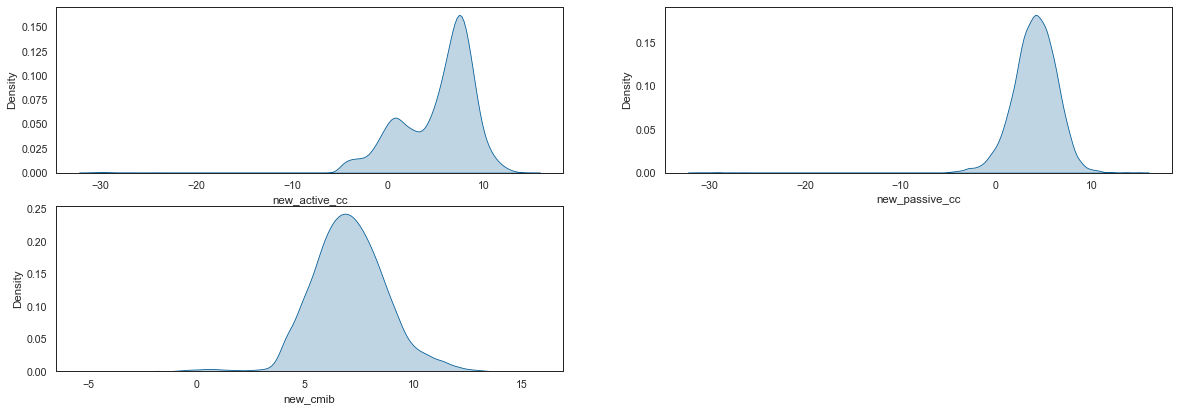

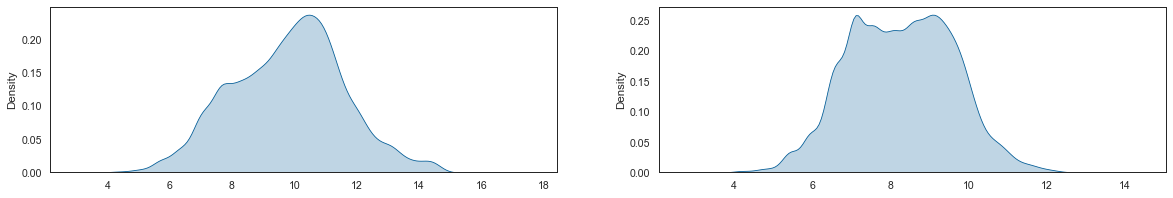

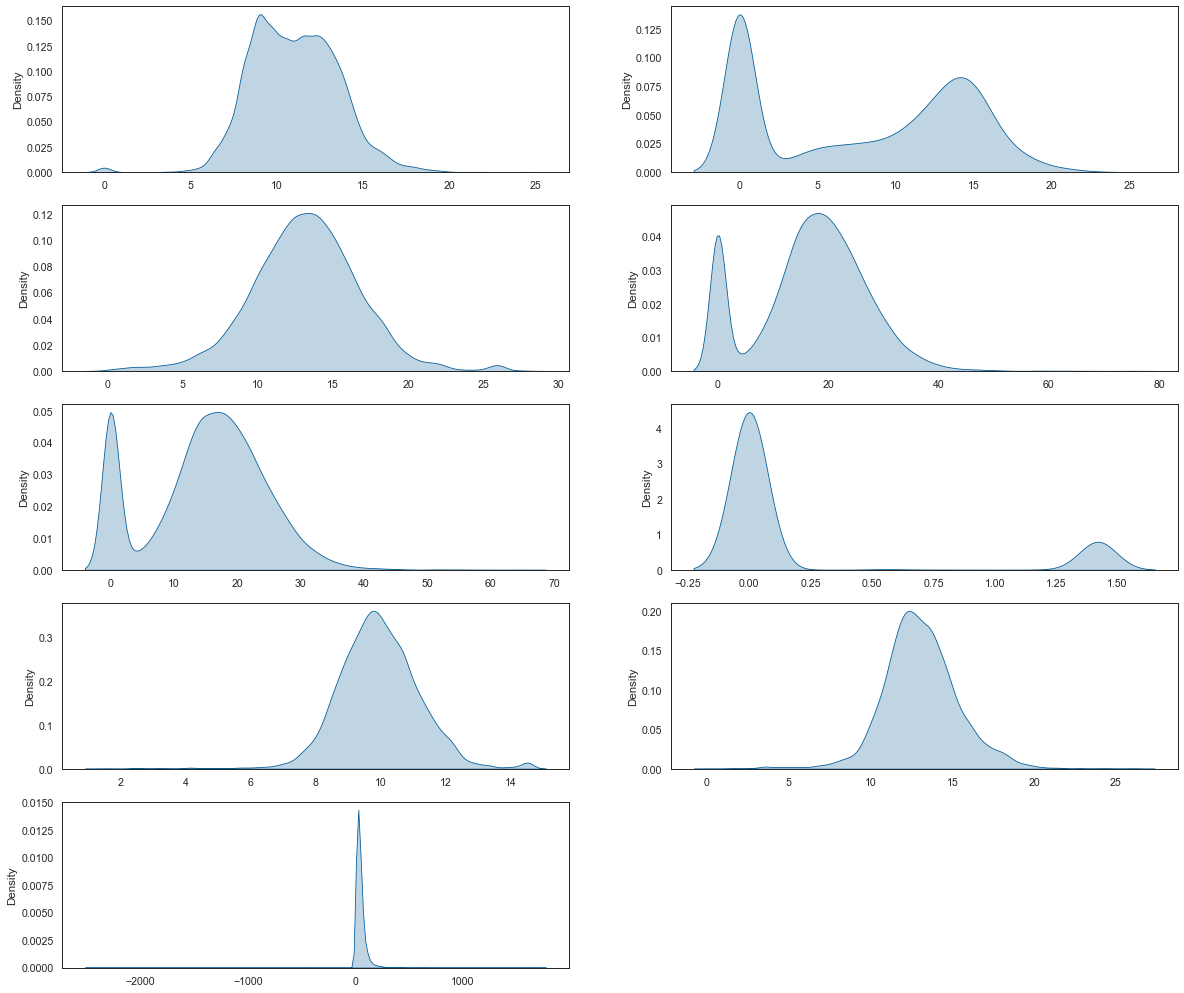

In [26]:
# we plot the features that should be logged

# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
sns.set_palette("BrBG_r")


plt.figure(figsize=(20,25))

for i, col in enumerate(log10):
    ax = plt.subplot(7,2, i+1)
    sns.kdeplot((np.log(log10[col])), color='#005b96', shade=True, ax = ax)
    
plt.show()

# we plot the features that should be box-coxxed

# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
sns.set_palette("BrBG_r")


plt.figure(figsize=(20,25))

for i, col in enumerate(box):
    ax = plt.subplot(7,2, i+1)
    sns.kdeplot(pd.Series(stats.boxcox(box[col])[0]), color='#005b96', shade=True, ax = ax)

plt.show()


# we plot the features that should be yen-transformed

# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
sns.set_palette("BrBG_r")


plt.figure(figsize=(20,25))

for i, col in enumerate(yeo):
    ax = plt.subplot(7,2, i+1)
    sns.kdeplot(pd.Series(scipy.stats.yeojohnson(yeo[col])[0]), color='#005b96', shade=True, ax = ax)

plt.show()
    


We then proceed to applying the transformations to the dataset.


<br>

**Non-Zero Transformation**
<br>

We transform the following financial variables: <br>
    - volume_firm -> box-cox <br>
    - volume -> box-cox <br>
    - loans_approved -> yeo-johnson <br>
    - loans_utilized -> yeo-johnson <br>
    - liabilities_firm -> yeo-johnson <br>
    - liabilities ->  yeo-johnson <br>
    - bank_liabilities -> yeo-johnson <br>
    - other_liabilities -> yeo-johnson <br>
    - pl_firm -> yeo-johnson <br>
    - pl -> yeo-johnson <br>
    - new_active_cc -> log10 <br>
    - new_passive_cc -> log10 <br>
    - new_commission_income -> yeo-johnson <br>
    - new_cmib -> log10

<br>

**Non-Zero Dataset**

In [27]:
# volume_firm

pt = PowerTransformer(method='box-cox')
pt.fit(tra_nonzero[['volume_firm']])
n_1 = pt.lambdas_

tra_nonzero['volume_firm'] = scipy.special.boxcox(tra_nonzero['volume_firm'], n_1)

# volume

pt = PowerTransformer(method='box-cox')
pt.fit(tra_nonzero[['volume']])
n_111 = pt.lambdas_

tra_nonzero['volume'] = scipy.special.boxcox(tra_nonzero['volume'], n_111)

# loans_approved

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_nonzero[['loans_approved']])
n_2 = pt.lambdas_

tra_nonzero['loans_approved'] = scipy.stats.yeojohnson(tra_nonzero['loans_approved'], n_2)

# loans_utilized

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_nonzero[['loans_utilized']])
n_3 = pt.lambdas_

tra_nonzero['loans_utilized'] = scipy.stats.yeojohnson(tra_nonzero['loans_utilized'], n_3)

# liabilities_firm

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_nonzero[['liabilities_firm']])
n_4 = pt.lambdas_

tra_nonzero['liabilities_firm'] = scipy.stats.yeojohnson(tra_nonzero['liabilities_firm'], n_4)

# liabilities

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_nonzero[['liabilities']])
n_5 = pt.lambdas_

tra_nonzero['liabilities'] = scipy.stats.yeojohnson(tra_nonzero['liabilities'], n_5)

# bank_liabilities

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_nonzero[['bank_liabilities']])
n_6 = pt.lambdas_

tra_nonzero['bank_liabilities'] = scipy.stats.yeojohnson(tra_nonzero['bank_liabilities'], n_6)

# other_liabilities

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_nonzero[['other_liabilities']])
n_7 = pt.lambdas_

tra_nonzero['other_liabilities'] = scipy.stats.yeojohnson(tra_nonzero['other_liabilities'], n_7)

# pl_firm

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_nonzero[['pl_firm']])
n_777 = pt.lambdas_

tra_nonzero['pl_firm'] = scipy.stats.yeojohnson(tra_nonzero['pl_firm'], n_777)

# pl

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_nonzero[['pl']])
n_8 = pt.lambdas_

tra_nonzero['pl'] = scipy.stats.yeojohnson(tra_nonzero['pl'], n_8)

# active_cc

tra_nonzero['new_active_cc'] = np.log(tra_nonzero['new_active_cc']+0.00001)  # we apply +0.00001 due to 0 values

# passive_cc

tra_nonzero['new_passive_cc'] = np.log(tra_nonzero['new_passive_cc']+0.00001) # we apply +0.00001 due to 0 values

# commission_income

pt = PowerTransformer(method='yeo-johnson')
pt.fit(tra_nonzero[['new_commission_income']])
n_888 = pt.lambdas_

tra_nonzero['new_commission_income'] = scipy.stats.yeojohnson(tra_nonzero['new_commission_income'], n_888)

# cmib

tra_nonzero['new_cmib'] = np.log(tra_nonzero['new_cmib']+0.00001) # we apply +0.00001 due to 0 values

#### Alternative

<br>

Below is the code for another package that could have been used to transform the features (i.e. stats). At the end, however, we decided to opt for the transformations with the scipy package for two reasons. Foremost, the package allows to input a specific lambda for the boxcox calculation and secondly because the package allows to easily re-transform the features into their original values.

<br>

In [28]:
# # this is another type of transformation which could have been used



# # Nonzero Dataset

# nonzero_df['volume_firm'] = pd.Series(stats.boxcox(nonzero_df['volume_firm']+ 5.01)[0])
# nonzero_df['volume'] = np.log(nonzero_df['volume']+5.01)
# nonzero_df['loans_approved'] = np.log(pd.Series(stats.boxcox(nonzero_df['loans_approved']+ 5.01)[0]))
# nonzero_df['loans_utilized'] = pd.Series(stats.boxcox(nonzero_df['loans_utilized']+ 5.01)[0])
# nonzero_df['liabilities_firm'] = pd.Series(stats.boxcox(nonzero_df['liabilities_firm']+ 5.01)[0])
# nonzero_df['liabilities'] = np.log(pd.Series(stats.boxcox(nonzero_df['liabilities']+ 5.01)[0]))
# nonzero_df['bank_liabilities'] =  np.log(pd.Series(stats.boxcox(nonzero_df['bank_liabilities']+ 5.01)[0]))
# nonzero_df['other_liabilities'] = pd.Series(stats.boxcox(nonzero_df['other_liabilities']+ 5.01)[0])
# nonzero_df['pl_firm'] = np.log(nonzero_df['pl_firm']+ 5.01)
# nonzero_df['pl'] = pd.Series(stats.boxcox(nonzero_df['pl']+ 5.01)[0])
# nonzero_df['new_passive_cc'] = np.log(nonzero_df['new_active_cc']+5.01)
# nonzero_df['new_passive_cc'] = np.log(nonzero_df['new_passive_cc']+5.01)
# nonzero_df['new_commission_income'] = np.log(nonzero_df['new_commission_income']+5.01)


# # Zero Dataset

# zero_df['volume_firm'] = pd.Series(stats.boxcox(zero_df['volume_firm']+ 5.01)[0])
# zero_df['liabilities_firm'] = pd.Series(stats.boxcox(zero_df['liabilities_firm']+ 5.01)[0])
# zero_df['liabilities'] = np.log(pd.Series(stats.boxcox(zero_df['liabilities']+ 5.01)[0]))
# zero_df['bank_liabilities'] =  np.log(pd.Series(stats.boxcox(zero_df['bank_liabilities']+ 5.01)[0]))
# zero_df['other_liabilities'] = pd.Series(stats.boxcox(zero_df['other_liabilities']+ 5.01)[0])
# zero_df['pl_firm'] = np.log(pd.Series(stats.boxcox(zero_df['pl_firm']+ 5.01)[0]))
# zero_df['pl'] = np.log(zero_df['pl']+ 5.01)
# zero_df['new_active_cc'] = np.log(zero_df['new_active_cc']+5.01)
# zero_df['new_passive_cc'] = np.log(zero_df['new_passive_cc']+5.01)
# zero_df['new_commission_income'] = np.log(zero_df['new_commission_income']+5.01)

<br>

<br>

Now that we have the datasets we can use the KNN Imputer to fix any potential NaN caused by the trasnformations.

<br>

In [29]:
# we use the KNN imputer in order to fill any potential missing value

imputer = KNNImputer()

# for the zero dataset

tra_zero = pd.DataFrame(imputer.fit_transform(tra_zero),columns=tra_zero.columns)

# for the nonzero dataset

tra_nonzero = pd.DataFrame(imputer.fit_transform(tra_nonzero),columns=tra_nonzero.columns)

In [30]:
# check the length of the zero dataframe

len(tra_zero)

5186

In [31]:
# check the length of the nonzero dataframe

len(tra_nonzero)

13807

<br>

Now that we have a clear segmentation between the zero and the non-zero values, and that the values have been transformed, we can proceed with further cleaning by assessing collinearity within the dataset.
<br>

## Correlation Matrix  <a class="anchor" id="22"></a>

<br>

### Zero DataSet <a class="anchor" id="vc"></a>

In [32]:
# Correlation Matrix

corr = tra_zero.corr()

mask = np.zeros_like(corr, dtype=bool)

mask[np.triu_indices_from(mask)] = True

corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1') 
 .set_precision(2))




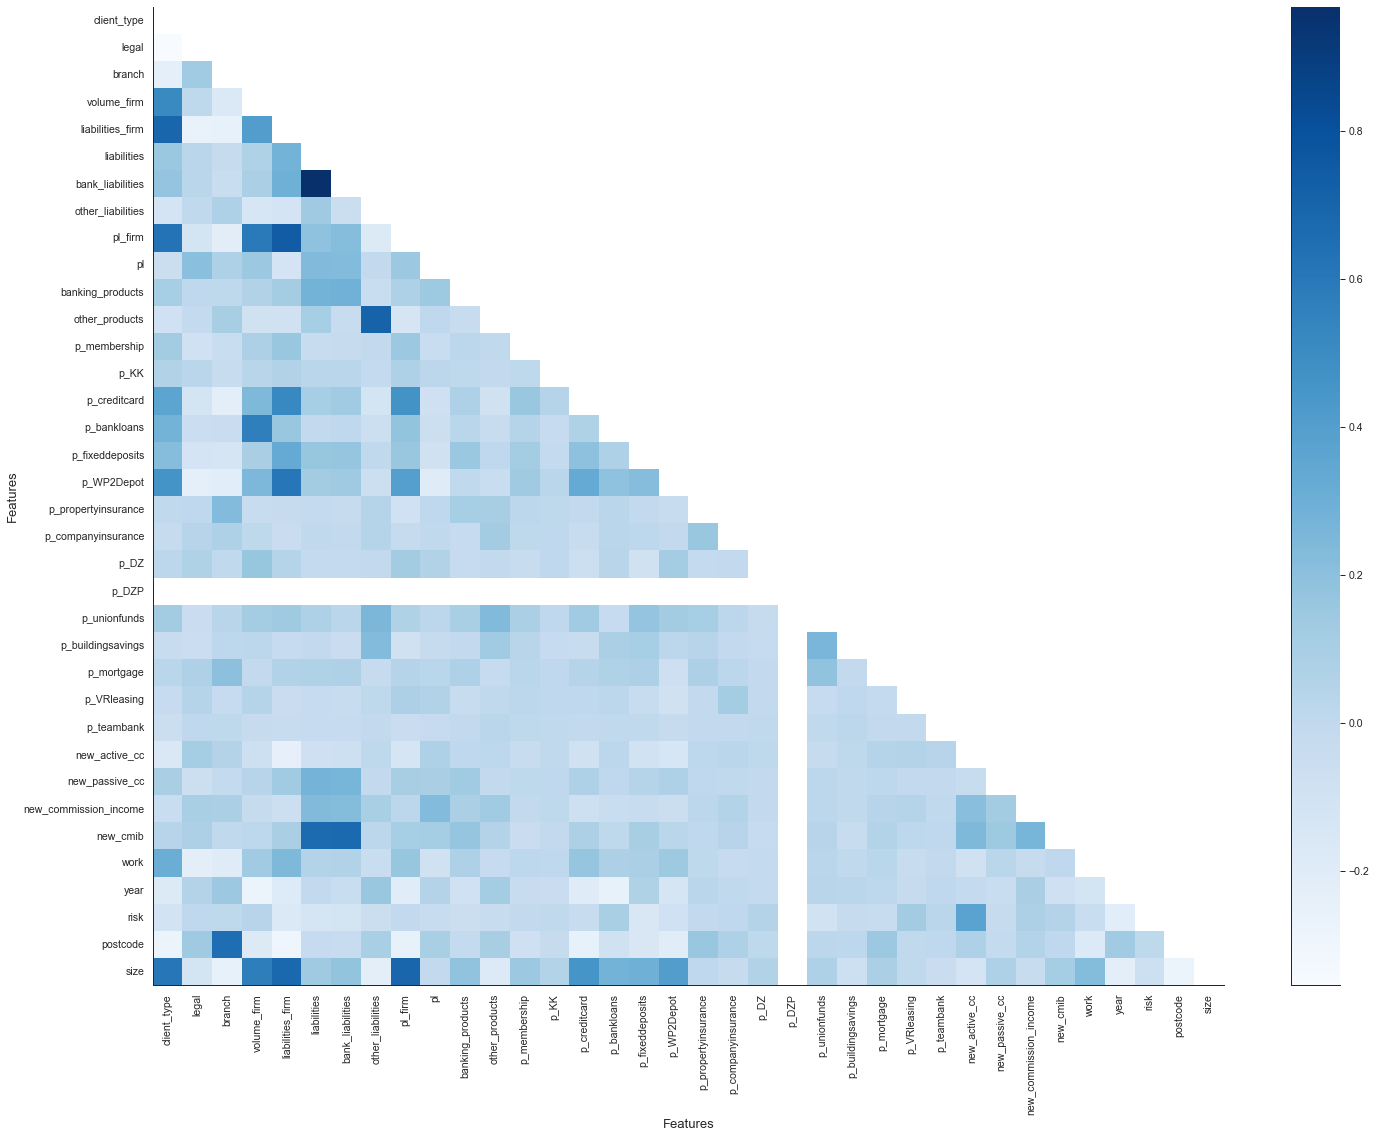

In [33]:
# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
sns.set_palette("BrBG_r")


fig, ax = plt.subplots(figsize=(24,18))


j = sns.heatmap(corr, cmap="Blues", ax=ax,)

sns.set(font_scale = 1)

# Set title, labels and ticks to each subplot
#ax.set_title('Correlation MAtrix for Zero Dataset', fontsize = 30, pad = 17)
ax.set_xlabel('Features', fontsize = 13)
ax.set_ylabel('Features', fontsize = 13)

# Adjust the distance between each subplot
plt.subplots_adjust(wspace = 0.8, hspace = 1.5)

plt.savefig('Correlation_zero.png', bbox_inches='tight', dmi=1200)

sns.despine()

<br>
To measure collinearity we use a cut-off point of 0.45. <br>

The variables that are correlated are the following: <br><br>
    - client_type and volume_firm <br>
    - client_type and liabilities_firm <br>
    - client_type and pl_firm<br>
    - client_type and p_WP2Depot <br>
    - client_type and size <br><br>
    - branch and postcode <br><br>
    - volume_firm and liabilities_firm <br>
    - volume_firm and pl_firm <br>
    - volume_firm and p_bankloans <br>
    - volume_firm and size <br> <br>
    - liabilities_firm and pl_firm <br>
    - liabilities_firm and p_creditcard <br>
    - liabilities_firm and p_WP2Depot <br>
    - liabilities_firm and size <br> <br>
    - liabilities and bank_liabilities<br>
    - liabilities and new_cmib<br><br>
    - bank_liabilities and new_cmib <br><br>
    - other_liabilities and other_products<br><br>
    - pl_firm and p_creditcard<br>
    - pl_firm and size<br><br>
    - p_credicard and size <br><br>
    - p_WP2Depot and size <br><br>
    <br>
    
We can further remove p_DZP.

<br>

In [34]:
# we drop the features that are depicting collinearity with other features in the dataset

final_zero = tra_zero.drop(columns=['branch', 'liabilities','pl_firm', 'other_products', 'p_WP2Depot', 
                                    'p_creditcard','p_bankloans','p_DZP', 'new_cmib', 'size'])

In [35]:
# we create a new dataset to segmenting per client type
# This will be used afterwards to conduct clustering at the specific level

# work for this is under section 'Further Segmentation'

temp_1 = final_zero.iloc[:, 0:33]

zero_0 = temp_1[temp_1['client_type'] == 0]
zero_1 = temp_1[temp_1['client_type'] == 1]
zero_2 = temp_1[temp_1['client_type'] == 2]
zero_3 = temp_1[temp_1['client_type'] == 3]
zero_4 = temp_1[temp_1['client_type'] == 4]

zero_0.drop(columns = ['client_type'], inplace=True)
zero_1.drop(columns = ['client_type'], inplace=True)
zero_2.drop(columns = ['client_type'], inplace=True)
zero_3.drop(columns = ['client_type'], inplace=True)
zero_4.drop(columns = ['client_type'], inplace=True)

In [36]:
# once we have client types for the sub-datasets, we can drop the feature

final_zero.drop(columns=['client_type'], inplace=True)

In [37]:
# New Matrix to check whether we still have collinearity amongst the variables

corr = final_zero.corr()

mask = np.zeros_like(corr, dtype=bool)

mask[np.triu_indices_from(mask)] = True

corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1') 
 .set_precision(2))

In [38]:
# highest correlations with P&L

#variable = last_df.corr()['P&L (Firm)'].to_frame()

#plt.figure(figsize=(5,10))
#sns.heatmap(variable[variable['P&L (Firm)'] != 1].sort_values(by='P&L (Firm)', 
#                                                                           ascending=False), annot=True)
#plt.title('Top 10 Fields with Highest Correlations with P&L')
#plt.show();

<br>

### Nonzero DataSet <a class="anchor" id="vcc"></a>

In [39]:
#Correlation Matrix

corr = tra_nonzero.corr()

mask = np.zeros_like(corr, dtype=bool)

mask[np.triu_indices_from(mask)] = True

corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1') 
 .set_precision(2))




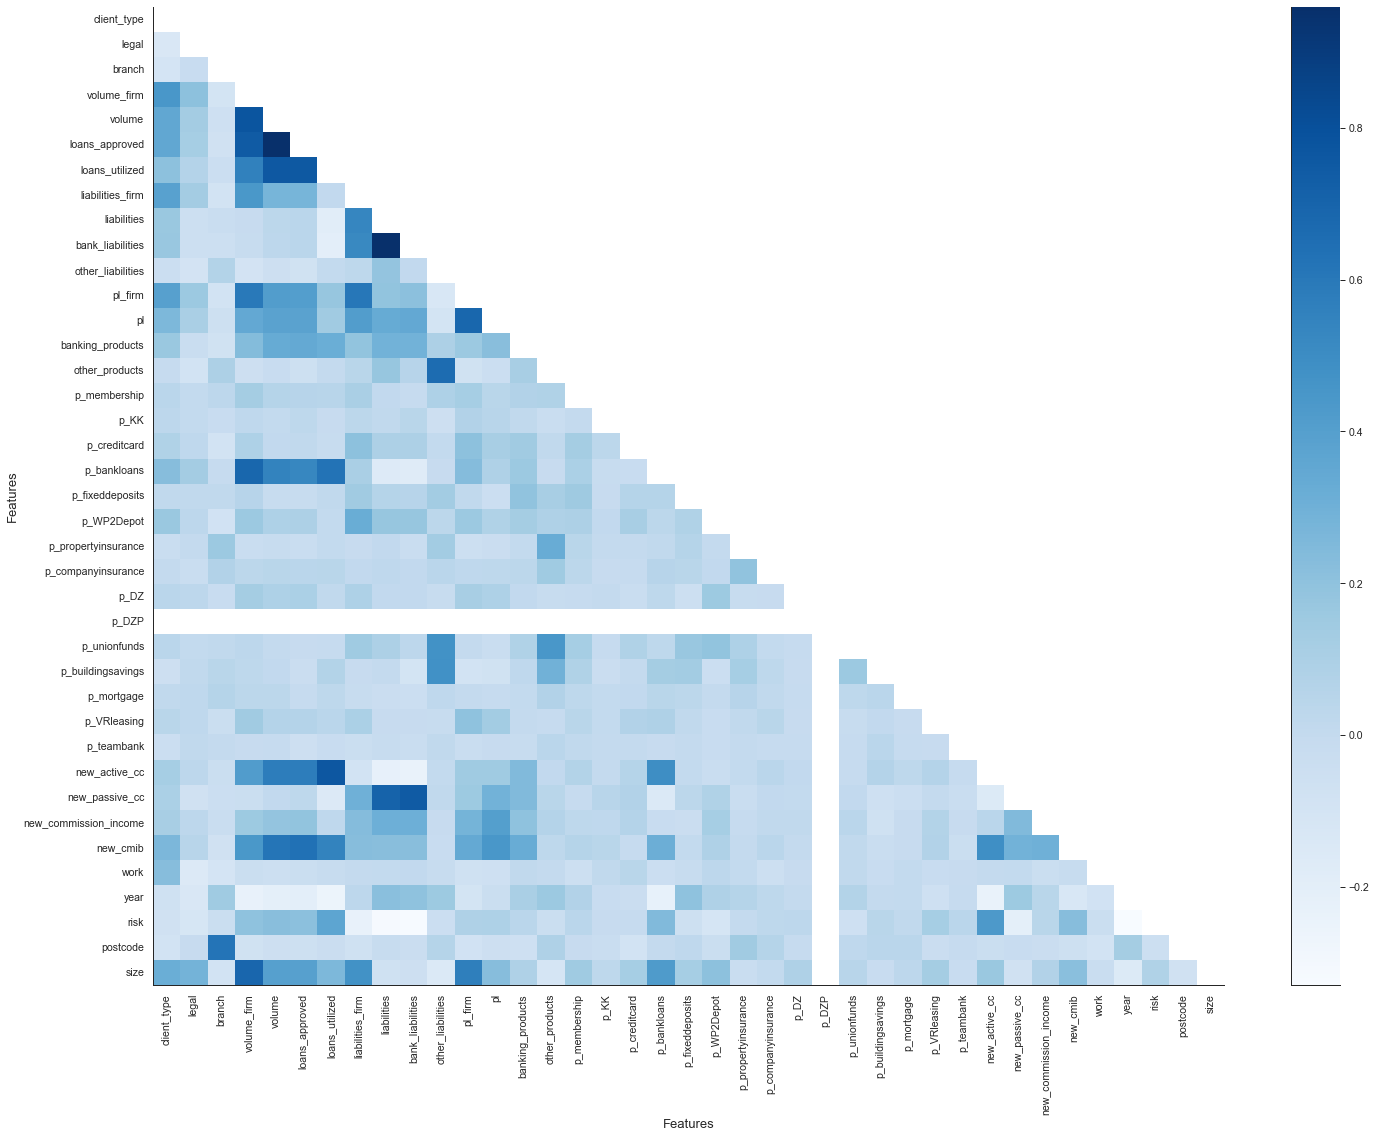

In [40]:
# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
sns.set_palette("BrBG_r")


fig, ax = plt.subplots(figsize=(24,18))


j = sns.heatmap(corr, cmap="Blues", ax=ax,)

sns.set(font_scale = 1)

# Set title, labels and ticks to each subplot
#ax.set_title('Correlation MAtrix for Nonzero Dataset', fontsize = 30, pad = 17)
ax.set_xlabel('Features', fontsize = 13)
ax.set_ylabel('Features', fontsize = 13)

# Adjust the distance between each subplot
plt.subplots_adjust(wspace = 0.8, hspace = 1.5)

plt.savefig('Correlation_nonzero.png', bbox_inches='tight', dmi=1200)

sns.despine()

<br>

The variables that are correlated are the following: <br><br>
    - client_type and volume_firm <br><br>
    - branch and postcode <br><br>
    - volume_firm and volume <br>
    - volume_firm and loans_approved <br>
    - volume_firm and loans_utilized <br>
    - volume_firm and pl_firm <br>
    - volume_firm and p_bankloans <br>
    - volume_firm and new_active_cc <br>
    - volume_firm and size <br><br>
    - volume and loans_approved <br>
    - volume and loans_utilized <br>
    - volume and p_bankloans <br>
    - volume and new_active_cc <br>
    - volume and new_cmib <br><br>
    - loans_approved and loans_utilized <br>
    - loans_approved and p_bankloans <br>
    - loans_approved and new_active_cc <br>
    - loans_approved and new_cmib <br><br> 
    - loans_utilized and p_bankloans <br>
    - loans_utilized and new_active_cc <br>
    - loans_utilized and new_cmib <br><br>
    - liabilities_firm and liabilities <br> 
    - liabilities_firm and bank_liabilities <br> 
    - liabilities_firm and pl_firm <br> 
    - liabilities_firm and size <br><br>
    - liabilities and bank_liabilities <br>
    - liabilities and new_passive_cc <br><br>
    - bank_liabilities and new_passive_cc <br><br>
    - other_liabilities and p_unionfunds <br>
    - other_liabilities and p_buildingsavings <br>
    - other_liabilities and other_products <br><br>
    - pl_firm and pl <br>
    - pl_firm and size <br> <br>
    - pl and new_cmib <br><br>
    - p_bankloans and and new_active_cc <br>
    - new_active_cc and new_cmib <br>
    - new_active_cc and risk <br><br>
<br>
<br>

In [41]:
# we drop the features that are depicting collinearity with other features in the dataset

final_nonzero = tra_nonzero.drop(columns=['branch', 'liabilities','liabilities_firm','volume', 'volume_firm', 'pl_firm', 
                                          'loans_utilized', 'other_products', 'p_unionfunds', 'p_buildingsavings',
                                          'p_bankloans', 'p_DZP', 'new_cmib', 'new_passive_cc', 'size'])


In [42]:
# we create a new dataset to segmenting per client type
# This will be used afterwards to conduct clustering at the specific level

# work for this is under section 'Further Segmentation'


temp_2 = final_nonzero.iloc[:, 0:35]

nonzero_0 = temp_2[temp_2['client_type'] == 0]
nonzero_1 = temp_2[temp_2['client_type'] == 1]
nonzero_2 = temp_2[temp_2['client_type'] == 2]
nonzero_3 = temp_2[temp_2['client_type'] == 3]
nonzero_4 = temp_2[temp_2['client_type'] == 4]

nonzero_0.drop(columns = ['client_type'], inplace=True)
nonzero_1.drop(columns = ['client_type'], inplace=True)
nonzero_2.drop(columns = ['client_type'], inplace=True)
nonzero_3.drop(columns = ['client_type'], inplace=True)
nonzero_4.drop(columns = ['client_type'], inplace=True)

In [43]:
# New Matrix to check whether we still have collinearity amongst the variables

corr = final_nonzero.corr()

mask = np.zeros_like(corr, dtype=bool)

mask[np.triu_indices_from(mask)] = True

corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1') 
 .set_precision(2))

<br>
<br>

<br>

## Scale the Data <a class="anchor" id="am"></a>

In [44]:
scaler = StandardScaler()

numer = final_zero[['volume_firm', 'liabilities_firm', 'bank_liabilities', 'other_liabilities',
       'pl', 'banking_products', 'new_active_cc','new_passive_cc', 'new_commission_income']]


cat = final_zero[['legal','p_membership', 'p_KK',
                  'p_fixeddeposits', 'p_propertyinsurance', 'p_companyinsurance', 'p_DZ',
                  'p_unionfunds', 'p_buildingsavings', 'p_mortgage', 'p_VRleasing',
                  'p_teambank', 'work', 'year', 'risk', 'postcode']]

numer = pd.DataFrame(scaler.fit_transform(numer))

final_zero = pd.concat([numer, cat], axis=1, join='inner')

In [45]:
final_zero.rename(columns = {0:'volume_firm', 
                             1: 'liabilities_firm',
                             2:'bank_liabilities',
                             3: 'other_liabilities',
                             4: 'pl',
                             5: 'banking_products',
                             6: 'new_active_cc',
                             7: 'new_passive_cc',
                             8: 'new_commission_income',
                             }, inplace = True)

In [46]:
numer = final_nonzero[['loans_approved', 'bank_liabilities',
                       'other_liabilities', 'pl', 'banking_products','new_active_cc', 'new_commission_income']]


cat = final_nonzero[['client_type', 'legal', 'p_membership', 'p_KK',
                     'p_creditcard', 'p_fixeddeposits', 'p_WP2Depot', 'p_propertyinsurance',
                     'p_companyinsurance', 'p_DZ', 'p_mortgage', 'p_VRleasing', 'p_teambank', 'work',
                     'year', 'risk', 'postcode']]

numer = pd.DataFrame(scaler.fit_transform(numer))

final_nonzero = pd.concat([numer, cat], axis=1, join='inner')

In [47]:
final_nonzero.rename(columns = {0:'loans_approved', 
                                1:'bank_liabilities',
                                2: 'other_liabilities',
                                3: 'pl',
                                4: 'banking_products',
                                5: 'new_active_cc',
                                6: 'new_commission_income',
                                }, inplace = True)

## Check Data Distribution <a class="anchor" id="dd"></a>

### Principal Component Analysis <a class="anchor" id="ddd"></a>

In [48]:
ppp = PCA(n_components=20)
ppp.fit_transform(final_zero)
ppp.explained_variance_ratio_.cumsum()

bbq = PCA(n_components = 2)
bbs= bbq.fit_transform(final_zero)

pc111 = bbs[:,0]
pc222 = bbs[:,1]

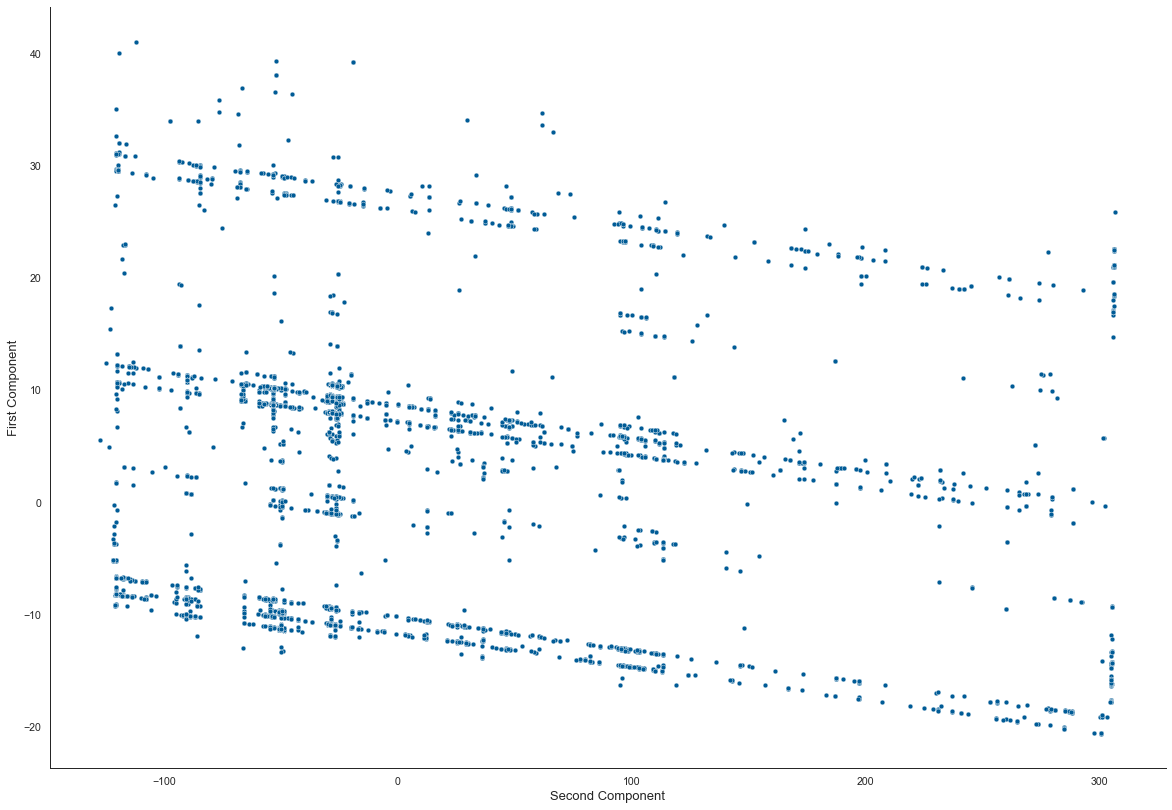

In [49]:
# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
#sns.set_palette("BrBG_r")


fig, ax = plt.subplots(figsize=(20,14))

sns.scatterplot(x=pc111, y=pc222, color='#005b96')


sns.set(font_scale = 1)


# Set title, labels and ticks to each subplot
#ax.set_title('Zero Dataset PCA projection', fontsize = 30, pad = 17)
ax.set_xlabel('Second Component', fontsize = 13)
ax.set_ylabel('First Component', fontsize = 13)


# Adjust the distance between each subplot
plt.subplots_adjust(wspace = 0.8, hspace = 1.5)

sns.despine()



#plt.savefig('PCA_zero.png', dmi=1200)

In [50]:
ppp = PCA(n_components=20)
ppp.fit_transform(final_nonzero)
ppp.explained_variance_ratio_.cumsum()

bbq = PCA(n_components = 2)
bbs= bbq.fit_transform(final_nonzero)

pc111 = bbs[:,0]
pc222 = bbs[:,1]

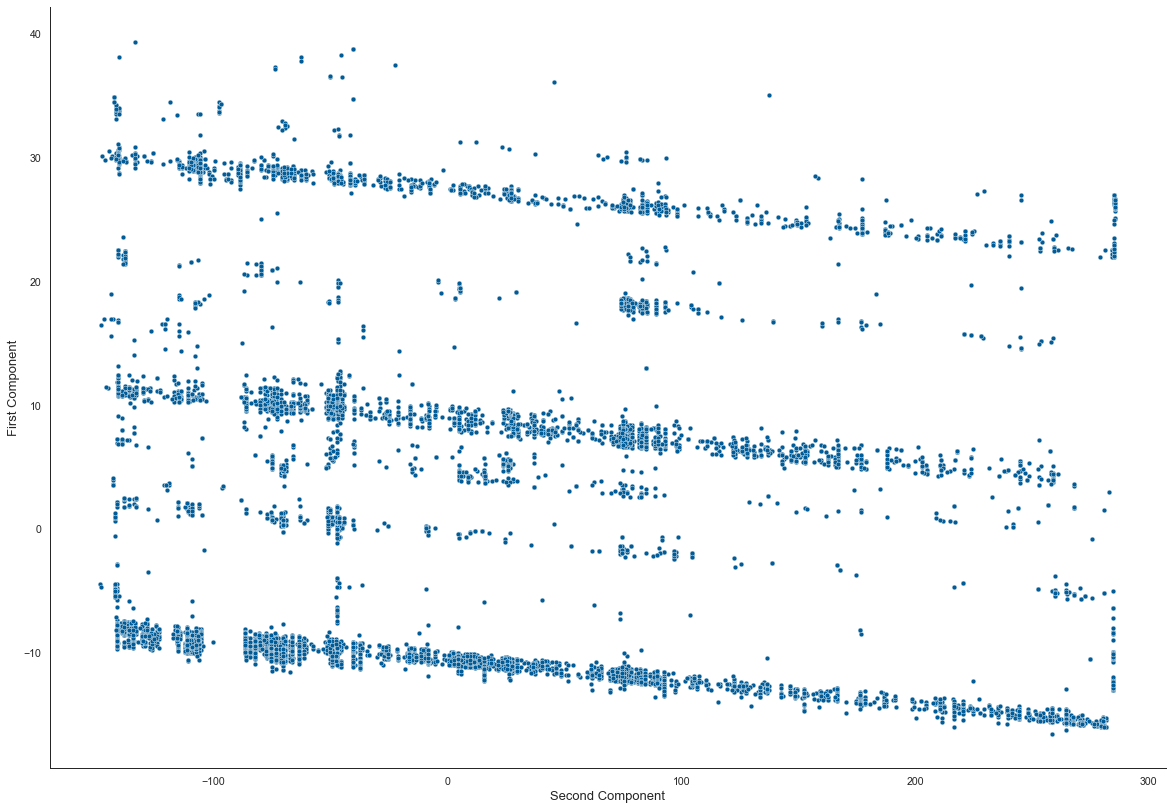

In [51]:
# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
#sns.set_palette("BrBG_r")


fig, ax = plt.subplots(figsize=(20,14))

sns.scatterplot(x=pc111, y=pc222, color='#005b96')


sns.set(font_scale = 1)


# Set title, labels and ticks to each subplot
#ax.set_title('Nonzero Dataset PCA projection', fontsize = 30, pad = 17)
ax.set_xlabel('Second Component', fontsize = 13)
ax.set_ylabel('First Component', fontsize = 13)


# Adjust the distance between each subplot
plt.subplots_adjust(wspace = 0.8, hspace = 1.5)

sns.despine()



#plt.savefig('PCA_zero.png', dmi=1200)

### t-SNE <a class="anchor" id="dddd"></a>

In [52]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(final_zero)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5186 samples in 0.001s...
[t-SNE] Computed neighbors for 5186 samples in 0.875s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5186
[t-SNE] Computed conditional probabilities for sample 2000 / 5186
[t-SNE] Computed conditional probabilities for sample 3000 / 5186
[t-SNE] Computed conditional probabilities for sample 4000 / 5186
[t-SNE] Computed conditional probabilities for sample 5000 / 5186
[t-SNE] Computed conditional probabilities for sample 5186 / 5186
[t-SNE] Mean sigma: 1.335009
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.236706
[t-SNE] KL divergence after 1000 iterations: 0.496822


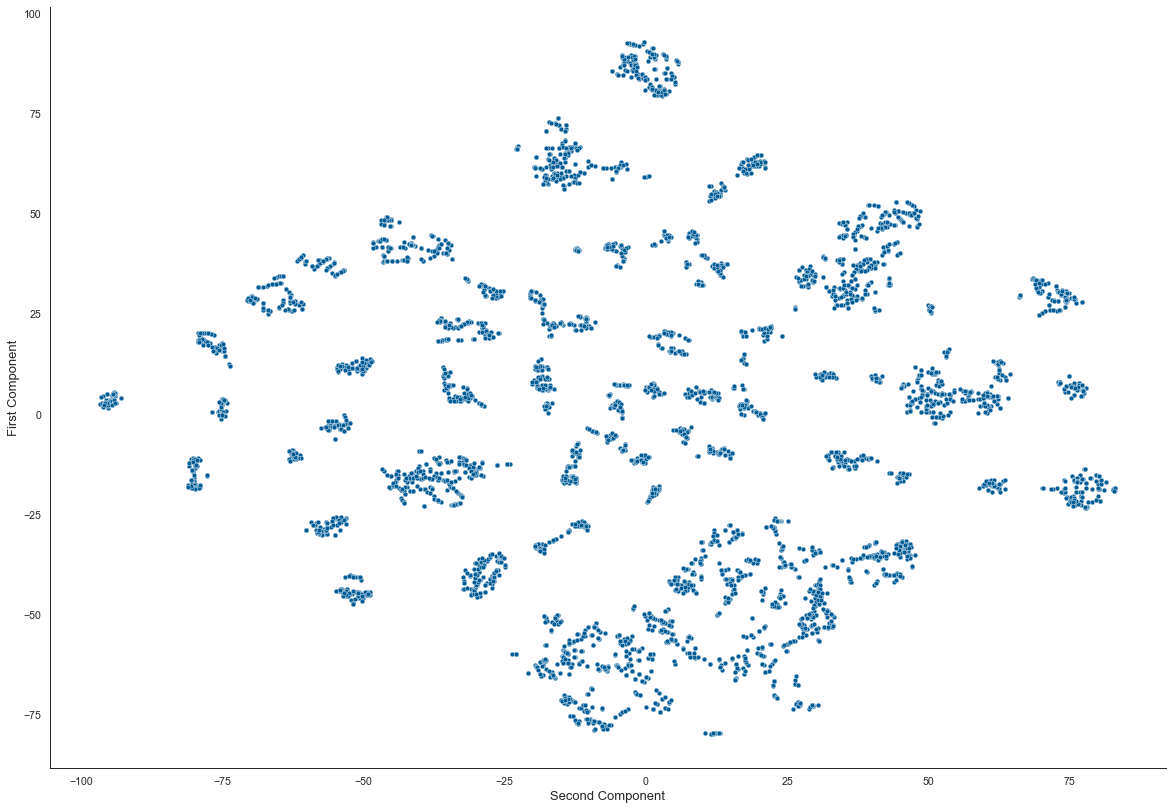

In [53]:
# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
#sns.set_palette("BrBG_r")


fig, ax = plt.subplots(figsize=(20,14))

sns.scatterplot(x=z[:,0], y=z[:,1],data=z, color='#005b96')


sns.set(font_scale = 1)


# Set title, labels and ticks to each subplot
#ax.set_title('Zero Dataset T-SNE projection', fontsize = 30, pad = 17)
ax.set_xlabel('Second Component', fontsize = 13)
ax.set_ylabel('First Component', fontsize = 13)


# Adjust the distance between each subplot
plt.subplots_adjust(wspace = 0.8, hspace = 1.5)

sns.despine()



#plt.savefig('PCA_zero.png', dmi=1200)

In [54]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(final_nonzero)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13807 samples in 0.000s...
[t-SNE] Computed neighbors for 13807 samples in 10.438s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13807
[t-SNE] Computed conditional probabilities for sample 2000 / 13807
[t-SNE] Computed conditional probabilities for sample 3000 / 13807
[t-SNE] Computed conditional probabilities for sample 4000 / 13807
[t-SNE] Computed conditional probabilities for sample 5000 / 13807
[t-SNE] Computed conditional probabilities for sample 6000 / 13807
[t-SNE] Computed conditional probabilities for sample 7000 / 13807
[t-SNE] Computed conditional probabilities for sample 8000 / 13807
[t-SNE] Computed conditional probabilities for sample 9000 / 13807
[t-SNE] Computed conditional probabilities for sample 10000 / 13807
[t-SNE] Computed conditional probabilities for sample 11000 / 13807
[t-SNE] Computed conditional probabilities for sample 12000 / 13807
[t-SNE] Computed conditional probabilities for sa

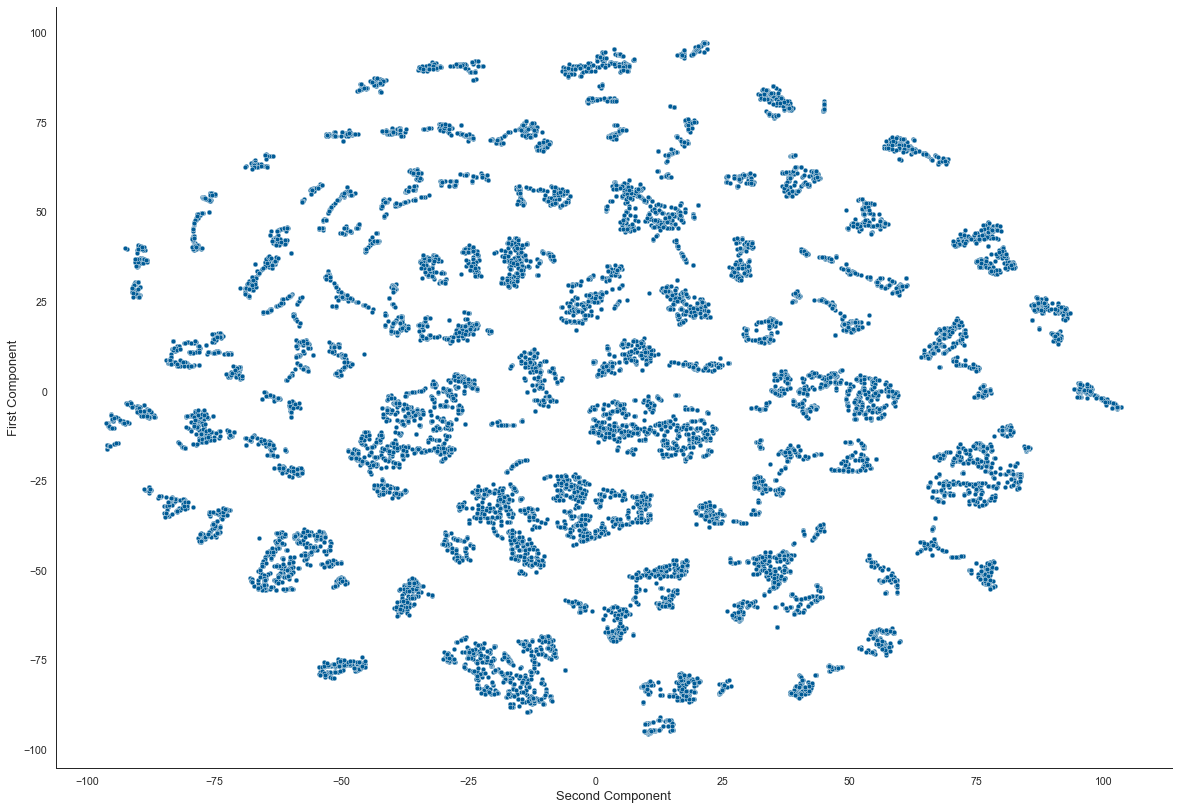

In [55]:
# set the basic format (i.e. the palette for the color and the backgrounds)
sns.set(rc={'axes.facecolor':'white'})
sns.set_context("paper", font_scale = 1.2)
sns.set_style("white")
#sns.set_palette("BrBG_r")


fig, ax = plt.subplots(figsize=(20,14))

sns.scatterplot(x=z[:,0], y=z[:,1],data=z, color='#005b96')


sns.set(font_scale = 1)


# Set title, labels and ticks to each subplot
#ax.set_title('Nonzero Dataset T-SNE projection', fontsize = 30, pad = 17)
ax.set_xlabel('Second Component', fontsize = 13)
ax.set_ylabel('First Component', fontsize = 13)


# Adjust the distance between each subplot
plt.subplots_adjust(wspace = 0.8, hspace = 1.5)

sns.despine()



#plt.savefig('PCA_zero.png', dmi=1200)

## Save Dataset  <a class="anchor" id="22.2"></a>

In [56]:
final_zero.to_csv('final_zero.csv')
tra_zero.to_csv('tra_zero.csv')
zero_df.to_csv('zero_df.csv')

final_nonzero.to_csv('final_nonzero.csv')
tra_nonzero.to_csv('tra_nonzero.csv')
nonzero_df.to_csv('nonzero_df.csv')